In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils

In [67]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)


### Paths definition

In [2]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [3]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [64]:
arr = np.ma.MaskedArray(**np.load(all_files[1454]))
arr.shape

(150, 93, 115)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

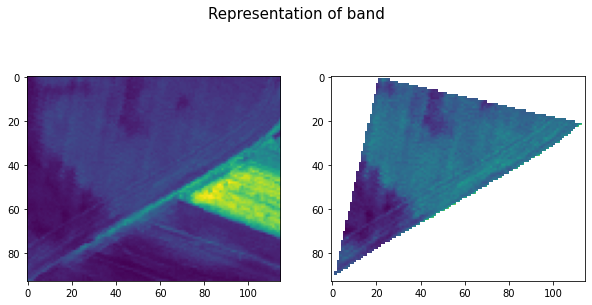

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 145

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [65]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,  359,  354,  ...,  268,  275,  268],
         [ 381,  345,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,  359,  360,  ...,  264,  269,  265],
         [ 377,  351,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,  356,  357,  ...,  258,  266,  257],
         [ 378,  348,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [66]:
tensor_data.shape

torch.Size([150, 93, 115])

In [67]:
tensor_mask_bool = torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [

In [73]:
tensor_mask_bool.shape

torch.Size([150, 93, 115])

In [177]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,    0,    0,  ...,  268,  275,  268],
         [ 381,    0,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,    0,    0,  ...,  264,  269,  265],
         [ 377,    0,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,    0,    0,  ...,  258,  266,  257],
         [ 378,    0,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [178]:
tensor_data_masked.shape

torch.Size([150, 93, 115])

In [285]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [286]:
pad_to_minimum_size(300, tensor_data_masked).shape

103.5 92.5
103 104 92 93


torch.Size([150, 300, 300])

### Load mean and std values of training dataset

In [3]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [425]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

tensor([[[-2.7990e+00, -2.9844e+00, -2.6931e+00,  ..., -1.8987e+00,
          -1.1307e+00, -2.6401e+00],
         [-3.4611e+00, -3.1698e+00, -2.7725e+00,  ..., -6.2756e-01,
          -1.1837e+00, -4.1570e-01],
         [-3.6464e+00, -3.4346e+00, -3.4346e+00,  ..., -1.1572e+00,
          -2.2694e+00, -2.0311e+00],
         ...,
         [-4.6867e-01, -1.0081e+01, -1.0081e+01,  ..., -2.9844e+00,
          -2.7990e+00, -2.9844e+00],
         [ 7.9982e-03, -1.0081e+01, -7.1446e-02,  ..., -2.2694e+00,
          -2.5607e+00, -2.4813e+00],
         [ 4.5818e-01,  1.2526e+00,  1.1467e+00,  ..., -2.2164e+00,
          -2.2429e+00, -1.6603e+00]],

        [[-2.8853e+00, -2.9117e+00, -2.8061e+00,  ..., -1.9079e+00,
          -1.0096e+00, -2.5683e+00],
         [-3.3080e+00, -3.1231e+00, -2.7268e+00,  ..., -6.1338e-01,
          -1.1153e+00, -2.1711e-01],
         [-3.4401e+00, -3.4137e+00, -3.4401e+00,  ..., -1.1153e+00,
          -2.2513e+00, -2.0928e+00],
         ...,
         [-3.7562e-01, -1

In [20]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [22]:
temp_gt

,P,K,Mg,pH
0,45.1,188.0,179.0,7.2
1,44.8,205.0,188.0,7.0
2,44.4,207.0,145.0,6.8
3,46.5,204.0,143.0,6.8
4,52.0,212.0,167.0,6.7
...,...,...,...,...
1727,40.8,133.0,132.0,6.2
1728,42.7,192.0,126.0,6.5
1729,39.4,180.0,122.0,6.5
1730,37.3,162.0,127.0,6.5


In [25]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [4]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=None, means=None, stds=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        img_tensor_mask = torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_normalized = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_normalized_padded = self.pad_to_minimum_size(300, img_masked_tensor_normalized)
            img_result_tensor = img_masked_tensor_normalized_padded
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [8]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds)

In [9]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Definition

In [5]:
import torchvision
from torchvision import datasets, models, transforms

In [68]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet34(pretrained=pretrained)
        
        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(512, 4, bias=True)
        
    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [6]:
class ResNext(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnext = models.resnext50_32x4d(pretrained=pretrained)
        self.resnext.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnext.fc = nn.Linear(in_features=2048, out_features=4, bias=True)
        
    def forward(self, x):
        x = self.resnext(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
BATCH_SIZE = 12
EPOCHS = 300

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)

### Overfitting on single batch of data

In [36]:
model = ResNext(pretrained=False)
model.to(device)

ResNext(
  (resnext): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [37]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [38]:
train_data_single_batch = next(iter(train_dataloader))

In [39]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [40]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [41]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([8, 150, 300, 300])

In [42]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [43]:
output

tensor([[-1.0939,  0.3983,  0.4350,  0.2339],
        [-0.9356,  0.2036,  0.4625,  0.1188],
        [-1.3139,  0.5412,  0.4767,  0.2955],
        [-1.3786,  0.5617,  0.3851,  0.4484],
        [-0.5153,  0.1654,  0.3404, -0.0326],
        [-0.6510,  0.2517,  0.3298,  0.0360],
        [-0.5711,  0.2107,  0.3376, -0.0054],
        [-0.5818,  0.2292,  0.3506,  0.0283]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[ 45.3000, 127.0000,  70.8000,  64.7000,  71.5000,  66.5000,  59.5000,
          79.1000],
        [212.0000, 382.0000, 243.0000, 181.0000, 180.0000, 285.0000, 202.0000,
         277.0000],
        [162.0000, 138.0000, 184.0000, 139.0000, 151.0000, 211.0000, 134.0000,
         160.0000],
        [  6.8000,   6.9000,   6.3000,   6.9000,   6.9000,   7.1000,   7.3400,
           6.6000]], dtype=torch.float64)

In [45]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [46]:
stacked_gt

tensor([[ 45.3000, 212.0000, 162.0000,   6.8000],
        [127.0000, 382.0000, 138.0000,   6.9000],
        [ 70.8000, 243.0000, 184.0000,   6.3000],
        [ 64.7000, 181.0000, 139.0000,   6.9000],
        [ 71.5000, 180.0000, 151.0000,   6.9000],
        [ 66.5000, 285.0000, 211.0000,   7.1000],
        [ 59.5000, 202.0000, 134.0000,   7.3400],
        [ 79.1000, 277.0000, 160.0000,   6.6000]], device='cuda:0',
       dtype=torch.float64)

In [47]:
loss_func(output, stacked_gt)

tensor(24033.7941, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [51]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

model = ResNext(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()
    
    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 24106.865234375, MSE: [5.8399673e+03 6.4314246e+04 2.6225582e+04 4.7668156e+01]
epoch: 10, loss: 2254.398681640625, MSE: [1713.4927 5696.3193 1586.2432   21.5396]
epoch: 20, loss: 541.23486328125, MSE: [ 413.82047    420.56894   1327.2218       3.3282251]
epoch: 30, loss: 288.69134521484375, MSE: [212.99036   204.05663   736.5945      1.1239157]
epoch: 40, loss: 166.59127807617188, MSE: [146.69464     53.987213   464.7804       0.90279424]
epoch: 50, loss: 184.13352966308594, MSE: [170.67621   106.903824  458.15073     0.8033737]
epoch: 60, loss: 130.607177734375, MSE: [141.08307   69.472855 311.49817    0.374604]
epoch: 70, loss: 96.1832504272461, MSE: [127.35413     49.01815    207.93784      0.42287666]
epoch: 80, loss: 76.226318359375, MSE: [113.53756    41.650135  149.09134     0.6262383]
epoch: 90, loss: 69.6544418334961, MSE: [102.08531    42.946762  133.12292     0.4628122]
epoch: 100, loss: 63.69031524658203, MSE: [ 94.62926    34.280506  125.599014    0.252469

### Training

In [95]:
model_name = 'resnext50_32x4d_BATCHSIZE_12_AdamW_LR_0_01_ReduceLROnPlateau_Factor0_2_Threshold_0_0001'

In [96]:
model = ResNext(False).to(device)

In [97]:
wandb.watch(model, log="None", log_freq=20)

[]

In [98]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [99]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [59]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [60]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [61]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.73E-03


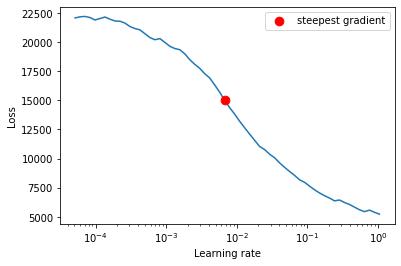

In [62]:
lr_finder.plot()
lr_finder.reset()

#### Continue training

In [100]:
patience_scheduler_overfit = 7
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.2, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [101]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [102]:
config = wandb.config
config.model = 'resnext50_32x4d'
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.2
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE

In [103]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [104]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = model(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = model(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2254.0849609375, train MSE: [1195.28466796875, 5425.35791015625, 2389.580322265625, 6.117173194885254]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1722.1781005859375, validation MSE: [827.5, 4180.05810546875, 1880.8426513671875, 0.31120574474334717]
Validation loss decreased (inf --> 1722.178101).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1632.0919189453125, train MSE: [989.2052612304688, 3861.451171875, 1677.5491943359375, 0.16172276437282562]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 1813.7802734375, validation MSE: [782.8551635742188, 4783.45361328125, 1688.3359375, 0.4759095013141632]
EarlyStopping counter: 1 out of 17


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1641.2388916015625, train MSE: [995.798583984375, 3872.28466796875, 1696.5438232421875, 0.32851114869117737]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 1710.526611328125, validation MSE: [835.542724609375, 4272.23486328125, 1733.9901123046875, 0.33788585662841797]
Validation loss decreased (1722.178101 --> 1710.526611).  Saving model ...


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1635.4466552734375, train MSE: [1004.79736328125, 3858.2431640625, 1678.5897216796875, 0.15641731023788452]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1707.3961181640625, validation MSE: [878.0317993164062, 4248.53857421875, 1702.8995361328125, 0.11386071890592575]
Validation loss decreased (1710.526611 --> 1707.396118).  Saving model ...


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1621.42431640625, train MSE: [999.039794921875, 3823.47607421875, 1663.05712890625, 0.12442948669195175]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1801.831787109375, validation MSE: [906.1675415039062, 4517.65576171875, 1783.4210205078125, 0.082645483314991]
EarlyStopping counter: 1 out of 17


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1605.2547607421875, train MSE: [984.6944580078125, 3769.140380859375, 1667.065185546875, 0.11854548007249832]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 1704.5023193359375, validation MSE: [847.1869506835938, 4333.4853515625, 1637.178955078125, 0.15736523270606995]
Validation loss decreased (1707.396118 --> 1704.502319).  Saving model ...


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1584.7440185546875, train MSE: [973.8853759765625, 3721.183837890625, 1643.7725830078125, 0.13466909527778625]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1666.5513916015625, validation MSE: [829.8482055664062, 4090.435791015625, 1745.6099853515625, 0.31146353483200073]
Validation loss decreased (1704.502319 --> 1666.551392).  Saving model ...


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 1575.95361328125, train MSE: [977.6409912109375, 3690.711669921875, 1635.336181640625, 0.12579935789108276]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 1730.49755859375, validation MSE: [863.360107421875, 4138.380859375, 1920.1666259765625, 0.08231309801340103]
EarlyStopping counter: 1 out of 17


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1581.6226806640625, train MSE: [976.4976806640625, 3709.989501953125, 1639.9071044921875, 0.09679660201072693]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1663.20703125, validation MSE: [844.62255859375, 4021.119140625, 1787.01025390625, 0.07636843621730804]
Validation loss decreased (1666.551392 --> 1663.207031).  Saving model ...


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1592.864990234375, train MSE: [965.9109497070312, 3755.37744140625, 1650.047607421875, 0.12455066293478012]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1683.005615234375, validation MSE: [840.581298828125, 4169.00732421875, 1722.35107421875, 0.08178947865962982]
EarlyStopping counter: 1 out of 17


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1562.233642578125, train MSE: [967.5514526367188, 3641.950439453125, 1639.3243408203125, 0.10861089825630188]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1746.02978515625, validation MSE: [875.1880493164062, 4160.18359375, 1948.677490234375, 0.06953027844429016]
EarlyStopping counter: 2 out of 17


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1533.435791015625, train MSE: [960.3452758789062, 3534.283447265625, 1639.0140380859375, 0.10007808357477188]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1656.70556640625, validation MSE: [812.7488403320312, 4018.829833984375, 1795.1866455078125, 0.05711686238646507]
Validation loss decreased (1663.207031 --> 1656.705566).  Saving model ...


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1525.0711669921875, train MSE: [959.7562866210938, 3531.6796875, 1608.7391357421875, 0.10945363342761993]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1671.633056640625, validation MSE: [824.7174682617188, 4025.395751953125, 1836.352294921875, 0.06687715649604797]
EarlyStopping counter: 1 out of 17


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 1521.60400390625, train MSE: [956.4595336914062, 3499.3427734375, 1630.5018310546875, 0.11176134645938873]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1691.6148681640625, validation MSE: [825.398681640625, 4051.96435546875, 1889.0318603515625, 0.06408654153347015]
EarlyStopping counter: 2 out of 17


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 1491.5113525390625, train MSE: [951.8703002929688, 3398.1962890625, 1615.871337890625, 0.10771510750055313]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1672.086669921875, validation MSE: [815.7000122070312, 4074.642822265625, 1797.9444580078125, 0.059296563267707825]
EarlyStopping counter: 3 out of 17


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 1479.1549072265625, train MSE: [948.2997436523438, 3351.372802734375, 1616.830810546875, 0.11592431366443634]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 3099.71337890625, validation MSE: [908.5244750976562, 9792.6708984375, 1697.3302001953125, 0.3275810778141022]
EarlyStopping counter: 4 out of 17


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 1476.7381591796875, train MSE: [948.420654296875, 3342.01904296875, 1616.3865966796875, 0.12612855434417725]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1673.4556884765625, validation MSE: [814.9354858398438, 4097.376953125, 1781.4400634765625, 0.06991836428642273]
EarlyStopping counter: 5 out of 17


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.01, train loss: 1455.3165283203125, train MSE: [944.2593383789062, 3273.914794921875, 1602.9599609375, 0.1316242665052414]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1661.5615234375, validation MSE: [816.28564453125, 4090.21533203125, 1739.6002197265625, 0.1447426825761795]
EarlyStopping counter: 6 out of 17


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.01, train loss: 1443.3779296875, train MSE: [944.0381469726562, 3237.910888671875, 1591.4293212890625, 0.13345065712928772]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1712.60205078125, validation MSE: [802.0335693359375, 4445.05029296875, 1603.183837890625, 0.13971462845802307]
EarlyStopping counter: 7 out of 17


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.01, train loss: 1434.3612060546875, train MSE: [938.7305908203125, 3202.28857421875, 1596.292236328125, 0.13285547494888306]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1666.3243408203125, validation MSE: [796.218505859375, 4056.3037109375, 1812.48876953125, 0.28570476174354553]
EarlyStopping counter: 8 out of 17


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.002, train loss: 1373.4976806640625, train MSE: [900.7306518554688, 3049.25341796875, 1543.92431640625, 0.08210825175046921]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1596.6180419921875, validation MSE: [761.8800659179688, 4053.140625, 1571.3787841796875, 0.07232573628425598]
Validation loss decreased (1656.705566 --> 1596.618042).  Saving model ...


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.002, train loss: 1334.3768310546875, train MSE: [891.1968383789062, 2916.25634765625, 1529.9803466796875, 0.07340487837791443]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1598.3858642578125, validation MSE: [763.9496459960938, 4068.8525390625, 1560.6640625, 0.0766981691122055]
EarlyStopping counter: 1 out of 17


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.002, train loss: 1304.08154296875, train MSE: [887.5905151367188, 2806.81787109375, 1521.84130859375, 0.07580957561731339]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1621.9622802734375, validation MSE: [767.6712036132812, 4153.93359375, 1566.140869140625, 0.10297711938619614]
EarlyStopping counter: 2 out of 17


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.002, train loss: 1278.5450439453125, train MSE: [885.1478271484375, 2714.106201171875, 1514.847412109375, 0.07835099846124649]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 1645.25439453125, validation MSE: [776.7160034179688, 4221.87451171875, 1582.3046875, 0.12196429818868637]
EarlyStopping counter: 3 out of 17


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.002, train loss: 1255.8876953125, train MSE: [884.4933471679688, 2631.87548828125, 1507.1019287109375, 0.07961982488632202]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 1639.891845703125, validation MSE: [776.6826782226562, 4196.40869140625, 1586.35595703125, 0.12036441266536713]
EarlyStopping counter: 4 out of 17


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.002, train loss: 1239.662841796875, train MSE: [886.2506103515625, 2575.981689453125, 1496.3367919921875, 0.08202420175075531]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 1626.485595703125, validation MSE: [767.81884765625, 4186.4189453125, 1551.624755859375, 0.07989101111888885]
EarlyStopping counter: 5 out of 17


epoch 26 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 26, LR: 0.002, train loss: 1222.902587890625, train MSE: [884.419677734375, 2508.339599609375, 1498.7705078125, 0.08039159327745438]


epoch 26 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 26, validation loss: 1661.5677490234375, validation MSE: [782.3660278320312, 4294.63232421875, 1569.1820068359375, 0.09056892991065979]
EarlyStopping counter: 6 out of 17


epoch 27 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 27, LR: 0.002, train loss: 1203.404052734375, train MSE: [879.60400390625, 2439.85400390625, 1494.0738525390625, 0.08435762673616409]


epoch 27 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 27, validation loss: 1665.8829345703125, validation MSE: [780.6403198242188, 4304.0322265625, 1578.7618408203125, 0.09730358421802521]
EarlyStopping counter: 7 out of 17


epoch 28 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 28, LR: 0.002, train loss: 1186.8489990234375, train MSE: [876.2056274414062, 2382.753173828125, 1488.351318359375, 0.08618507534265518]


epoch 28 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 28, validation loss: 1708.1634521484375, validation MSE: [784.196533203125, 4473.88232421875, 1574.4989013671875, 0.07603511214256287]
EarlyStopping counter: 8 out of 17


epoch 29 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 29, LR: 0.0004, train loss: 1160.3414306640625, train MSE: [864.7326049804688, 2296.451171875, 1480.10302734375, 0.078839510679245]


epoch 29 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 29, validation loss: 1677.488037109375, validation MSE: [767.34765625, 4375.1025390625, 1567.4171142578125, 0.08464795351028442]
EarlyStopping counter: 9 out of 17


epoch 30 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 30, LR: 0.0004, train loss: 1113.1114501953125, train MSE: [858.5782470703125, 2128.386962890625, 1465.39892578125, 0.08100463449954987]


epoch 30 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 30, validation loss: 1686.7161865234375, validation MSE: [770.8222045898438, 4414.28955078125, 1561.6680908203125, 0.0846572071313858]
EarlyStopping counter: 10 out of 17


epoch 31 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 31, LR: 0.0004, train loss: 1088.6961669921875, train MSE: [855.6616821289062, 2038.865966796875, 1460.17333984375, 0.08313124626874924]


epoch 31 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 31, validation loss: 1703.2943115234375, validation MSE: [776.935302734375, 4474.11962890625, 1562.035888671875, 0.08586140722036362]
EarlyStopping counter: 11 out of 17


epoch 32 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 32, LR: 0.0004, train loss: 1069.4317626953125, train MSE: [852.6629638671875, 1968.851318359375, 1456.12744140625, 0.08522804826498032]


epoch 32 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 32, validation loss: 1720.2806396484375, validation MSE: [782.455810546875, 4537.98046875, 1560.60009765625, 0.08655344694852829]
EarlyStopping counter: 12 out of 17


epoch 33 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 33, LR: 0.0004, train loss: 1051.4849853515625, train MSE: [850.0813598632812, 1904.7066650390625, 1451.06494140625, 0.08724735677242279]


epoch 33 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 33, validation loss: 1736.7530517578125, validation MSE: [786.915283203125, 4593.0615234375, 1566.94482421875, 0.09003537893295288]
EarlyStopping counter: 13 out of 17


epoch 34 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 34, LR: 0.0004, train loss: 1035.3936767578125, train MSE: [847.5479125976562, 1845.9140625, 1448.023681640625, 0.08921138197183609]


epoch 34 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 34, validation loss: 1749.757568359375, validation MSE: [791.3577880859375, 4641.3291015625, 1566.2525634765625, 0.09100592881441116]
EarlyStopping counter: 14 out of 17


epoch 35 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 35, LR: 0.0004, train loss: 1019.2164306640625, train MSE: [844.4556274414062, 1787.9033203125, 1444.41552734375, 0.09125195443630219]


epoch 35 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 35, validation loss: 1773.1334228515625, validation MSE: [795.9217529296875, 4724.3955078125, 1572.1224365234375, 0.09437303245067596]
EarlyStopping counter: 15 out of 17


epoch 36 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 36, LR: 0.0004, train loss: 1002.4171752929688, train MSE: [840.4111938476562, 1728.911376953125, 1440.25244140625, 0.09335985779762268]


epoch 36 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 36, validation loss: 1790.0078125, validation MSE: [800.8506469726562, 4784.2353515625, 1574.846923828125, 0.09769067913293839]
EarlyStopping counter: 16 out of 17


epoch 37 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 37, LR: 8e-05, train loss: 981.7981567382812, train MSE: [835.23486328125, 1656.9913330078125, 1434.875732421875, 0.09033893793821335]


epoch 37 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 37, validation loss: 1821.9508056640625, validation MSE: [796.05224609375, 4881.21435546875, 1610.4327392578125, 0.10399860143661499]
EarlyStopping counter: 17 out of 17
Early stopping


In [105]:
torch.save(model.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [8]:
# load saved model
modelLoad = ResNext(False)
modelLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'checkpoint_state_dict_ResNext50_28_02_2022.pth')))

<All keys matched successfully>

In [9]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [10]:
modelLoad.eval()

ResNext(
  (resnext): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [14]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds)

In [15]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=2)

In [16]:
len(test_data)

1154

In [ ]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

In [ ]:
submission.to_csv(os.path.join(submissions_directory, "submission_28_02_2022_2_ResNext_Checkpoint.csv"), index_label="sample_index")